Usando o exemplo 499

In [1]:
%pip install pandas numpy seaborn tensorflow
%pip install nltk
%pip install lime
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt


from lime import lime_text
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

# Camada de Atenção (Mover para antes da definição do modelo)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(name='att_W', shape=(input_shape[-1], 1), initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[1], 1), initializer='normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et, axis=1)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        output = K.sum(output, axis=1)
        self.attention_weights = at  # Armazenar os pesos para visualização
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super().get_config().copy()
        return config

In [3]:
df = pd.read_csv('all-data.csv')

In [4]:
df.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
df.shape

(4846, 2)

<Axes: xlabel='sentiment', ylabel='count'>

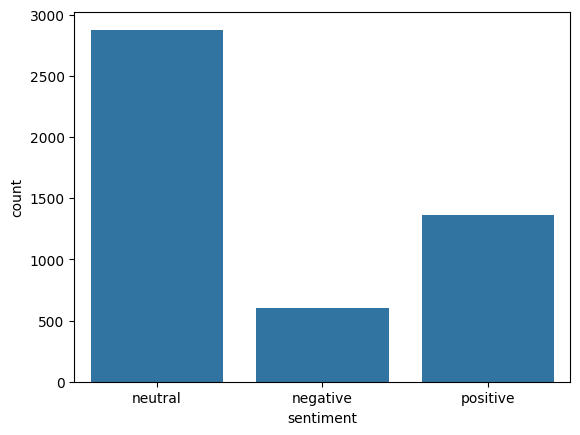

In [6]:
sns.countplot(x='sentiment', data=df)

**Pré-Processamento**

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [9]:
df["clean_text"] = df["text"].apply(preprocess_text)

In [10]:
df.head(5)

,sentiment,text,clean_text
0,neutral,"According to Gran , the company has no plans t...",according gran company plan move production ru...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,according company updated strategy year baswar...


<Axes: xlabel='sentiment', ylabel='count'>

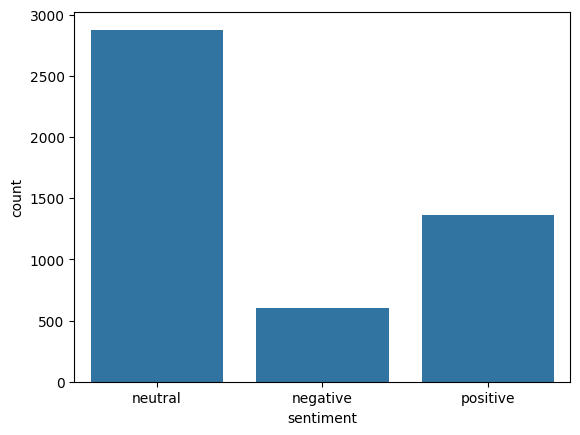

In [11]:
sns.countplot(x="sentiment", data=df) # validando se mudou as classes

In [12]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['sentiment'])

In [13]:
X = df['clean_text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#, stratify=y

In [14]:
#tokenização e padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

**LSTM**

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [16]:
# Definir o modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))  # LSTM com retorno de sequências para atenção
model.add(AttentionLayer())  # Adicionar a camada de atenção
model.add(Dense(3, activation='softmax'))  # 3 saídas para sentimentos (negativo, neutro, positivo)

c:\Users\CADASTRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy se y_train for numérico
              metrics=['accuracy'])

In [18]:
# Treinar o modelo
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)  # Validação durante o treinamento

Epoch 1/10


c:\Users\CADASTRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['sequential/attention_layer/att_u'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


109/109 ━━━━━━━━━━━━━━━━━━━━ 98s 556ms/step - accuracy: 0.5796 - loss: 0.9508 - val_accuracy: 0.6314 - val_loss: 0.8571
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 63s 379ms/step - accuracy: 0.6564 - loss: 0.7913 - val_accuracy: 0.6418 - val_loss: 0.8154
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 43s 398ms/step - accuracy: 0.7501 - loss: 0.6057 - val_accuracy: 0.6778 - val_loss: 0.7549
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 75s 325ms/step - accuracy: 0.8473 - loss: 0.4165 - val_accuracy: 0.6727 - val_loss: 0.7958
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 41s 372ms/step - accuracy: 0.9041 - loss: 0.2959 - val_accuracy: 0.7113 - val_loss: 0.8976
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 435ms/step - accuracy: 0.9333 - loss: 0.2118 - val_accuracy: 0.6778 - val_loss: 1.0210
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.9441 - loss: 0.1817 - val_accuracy: 0.6830 - val_loss: 1.2817
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 258ms/step - accuracy: 0.9573 - loss: 0.1371 - val

**OVERSAMPLING**

In [19]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)  # Define um estado aleatório para reprodutibilidade
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_pad, y_train)

In [20]:
# treino do modelo com os dados desbalanceados
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/10


c:\Users\CADASTRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['sequential/attention_layer/att_u'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 342ms/step - accuracy: 0.9332 - loss: 0.2264 - val_accuracy: 0.9582 - val_loss: 0.1859
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 95s 408ms/step - accuracy: 0.9588 - loss: 0.1425 - val_accuracy: 0.9567 - val_loss: 0.1316
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 389ms/step - accuracy: 0.9726 - loss: 0.0969 - val_accuracy: 0.9553 - val_loss: 0.1245
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 64s 289ms/step - accuracy: 0.9814 - loss: 0.0717 - val_accuracy: 0.9394 - val_loss: 0.2361
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 93s 345ms/step - accuracy: 0.9732 - loss: 0.0833 - val_accuracy: 0.9841 - val_loss: 0.0728
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 83s 350ms/step - accuracy: 0.9842 - loss: 0.0564 - val_accuracy: 0.9798 - val_loss: 0.0506
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 54s 278ms/step - accuracy: 0.9854 - loss: 0.0442 - val_accuracy: 0.9769 - val_loss: 0.0603
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 244ms/step - accuracy: 0.9904 - loss: 0.0324 - val

<Axes: xlabel='label_encoded', ylabel='count'>

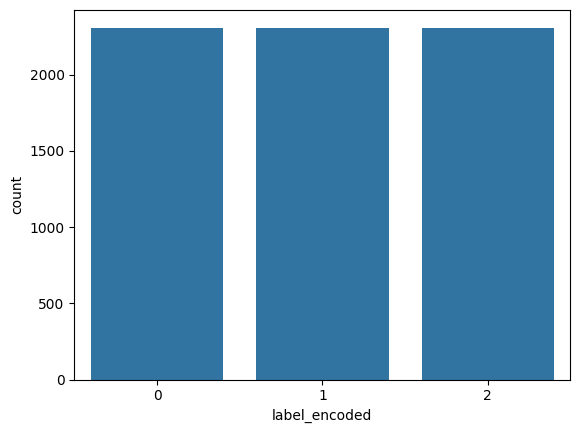

In [21]:
#verificar a nova distribuição de classes
sns.countplot(x=y_train_resampled)

**Métricas**

In [22]:
from sklearn.metrics import classification_report

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred_classes))


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step
              precision    recall  f1-score   support

           0       0.57      0.60      0.59       110
           1       0.78      0.81      0.80       571
           2       0.62      0.56      0.59       289

    accuracy                           0.71       970
   macro avg       0.66      0.66      0.66       970
weighted avg       0.71      0.71      0.71       970



In [23]:
#acuracia,precisão, recall e f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1
# Calcular as métricas
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred_classes)
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acurácia: 0.7134
Precisão: 0.7101
Recall: 0.7134
F1-Score: 0.7111


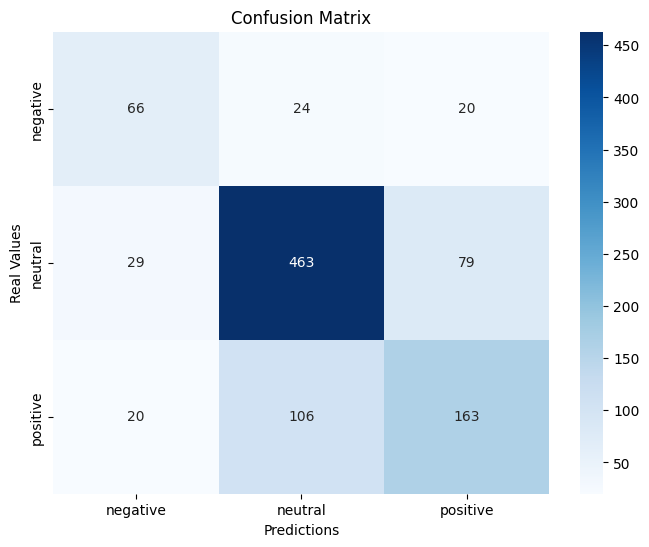

In [24]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Criar o heatmap da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predictions")
plt.ylabel("Real Values")
plt.title("Confusion Matrix")
plt.show()

**LIME**

In [25]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=le.classes_)

def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    predictions = model.predict(padded_sequences)
    return predictions  # Já retorna probabilidades (softmax)

# Solicita ao usuário o número da linha do exemplo
idx = int(input(f"Digite o número da linha (0 a {len(X_test)-1}): "))
sample_text = X_test.iloc[idx]
sample_label = y_test.iloc[idx]

# Predição da classe para o texto selecionado
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_pad = pad_sequences(sample_seq, maxlen=max_len)
pred_probs = model.predict(sample_pad)
pred_class_idx = pred_probs.argmax(axis=1)[0]
pred_class_name = le.classes_[pred_class_idx]

print(f"Número da linha no X_test: {idx}")
print(f"Original text:\n{sample_text}")
print(f"Classe real: {le.classes_[sample_label]}")
print(f"Classe predita: {pred_class_name}")

explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

print(explanation.as_list())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
Número da linha no X_test: 499
Original text:
preliminary estimation technology park measure square meter
Classe real: neutral
Classe predita: neutral
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step
[(np.str_('estimation'), 0.16970479376997052), (np.str_('technology'), -0.09333367115136272), (np.str_('preliminary'), -0.09272518444728595), (np.str_('park'), -0.08842933061280724), (np.str_('measure'), -0.07770230628711783), (np.str_('meter'), -0.0303230056802825), (np.str_('square'), 0.02002876650097322)]


In [26]:
# Obtém as palavras mais importantes e seus pesos
lime_features = explanation.as_list()

# Exibe cada palavra com seu impacto na predição
print("Palavras mais importantes e seus pesos:")
for word, weight in lime_features:
    print(f"{word}: {weight:.4f}")

Palavras mais importantes e seus pesos:
estimation: 0.1697
technology: -0.0933
preliminary: -0.0927
park: -0.0884
measure: -0.0777
meter: -0.0303
square: 0.0200


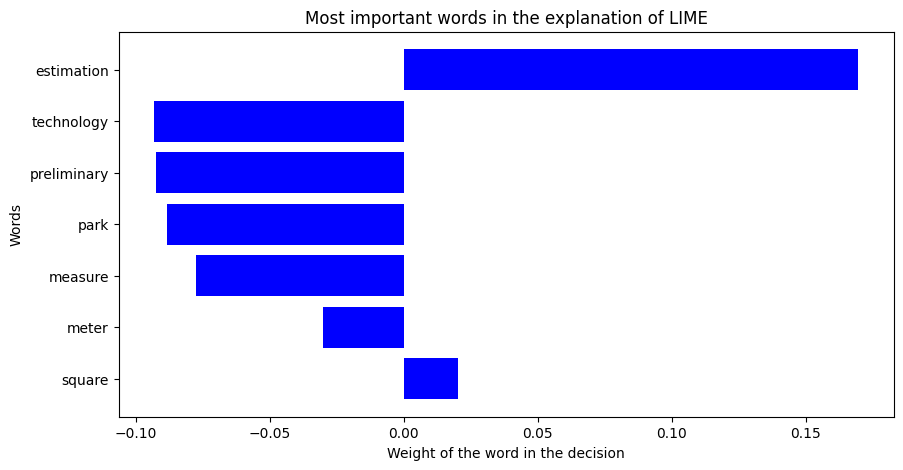

In [27]:
# Separar palavras e pesos
words, weights = zip(*lime_features)

# Criar gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(words, weights, color="blue")
plt.xlabel("Weight of the word in the decision")
plt.ylabel("Words")
plt.title("Most important words in the explanation of LIME")
plt.gca().invert_yaxis()  # Inverter para mostrar a palavra mais importante no topo
plt.show()

In [28]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Imprimir as palavras e pesos
for word, weight in words_weights:
    print(f"{word}: {weight}")

estimation: 0.16970479376997052
technology: -0.09333367115136272
preliminary: -0.09272518444728595
park: -0.08842933061280724
measure: -0.07770230628711783
meter: -0.0303230056802825
square: 0.02002876650097322


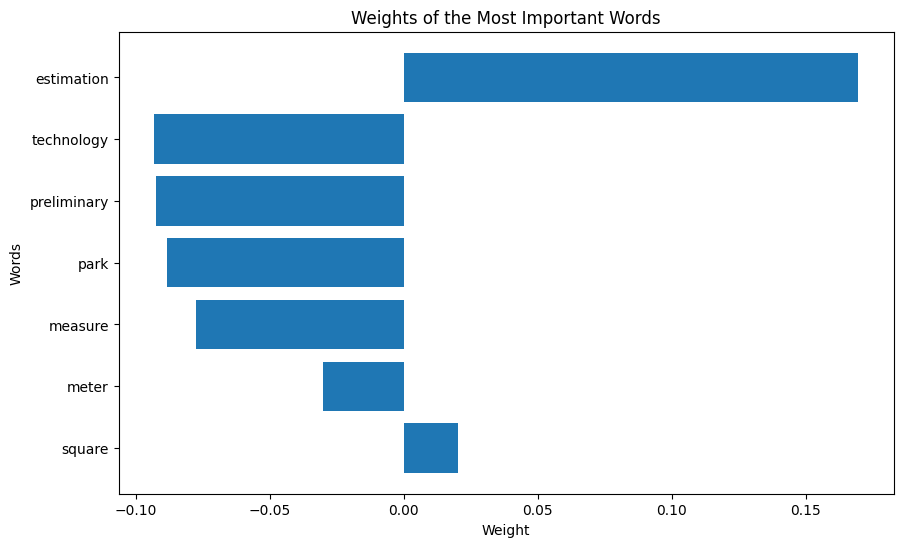

In [29]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Separar palavras e pesos em listas separadas
words = [word for word, weight in words_weights]
weights = [weight for word, weight in words_weights]

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))  # Ajustar o tamanho da figura, se necessário
plt.barh(words, weights)
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Weights of the Most Important Words")
plt.gca().invert_yaxis()  # Inverter o eixo y para que as palavras mais importantes estejam no topo
plt.show()

**Attention Viz**

In [30]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
A classe prevista para o texto é o índice: 1

Palavras do exemplo e seus pesos na decisão da classe prevista (LSTM):
          Feature    Weight
595        square  0.427090
3583   estimation  0.386568
260       measure  0.161260
1600        meter  0.056753
40     technology -0.230773
477          park -0.238884
1383  preliminary -0.277249


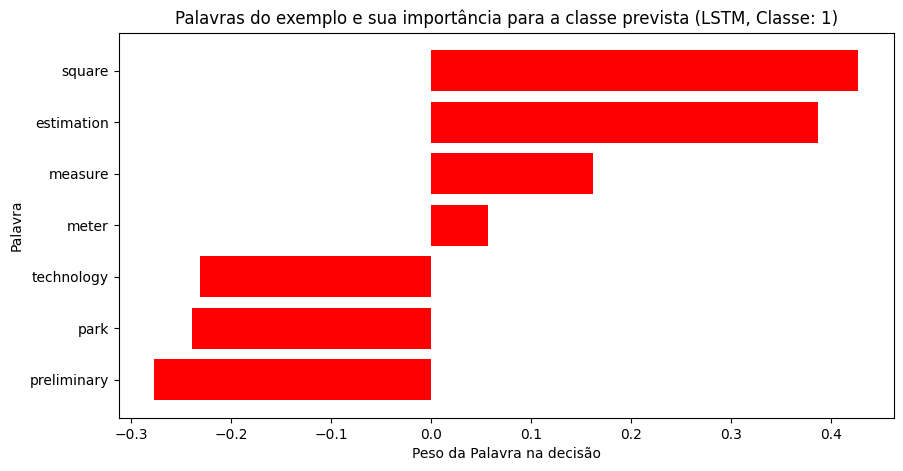

In [40]:
# Definir o texto de exemplo
sample_text = "preliminary estimation technology park measure square meter"

# **Etapa 1: Calcular a importância das palavras para cada classe do modelo LSTM**

# Obter os pesos da camada de Embedding
# Supondo que a camada de embedding é a primeira (índice 0)
embedding_weights = model.layers[0].get_weights()[0]

# Usar tokenizer.index_word para obter as palavras a partir dos índices
nomes_das_features = [tokenizer.index_word.get(i, '<OOV>') for i in range(1, embedding_weights.shape[0] + 1)]

# Obter os pesos da camada Dense (a última camada de saída)
dense_weights = model.layers[-1].get_weights()[0]

# Calcular a importância das palavras para cada classe
num_classes = dense_weights.shape[1]  # Número de classes de saída
importancias_das_features = []
for class_index in range(num_classes):
    # Obter os pesos da camada Dense para a classe atual
    class_weights = dense_weights[:, class_index]

    # Calcular a importância das palavras multiplicando os pesos da camada Dense pelos pesos da camada de Embedding
    word_importances = np.dot(embedding_weights, class_weights)

    importancias_da_classe = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
    importancias_da_classe = importancias_da_classe.sort_values(by='Weight', ascending=False)
    importancias_das_features.append(importancias_da_classe)

# **Etapa 2: Prever a classe do sample_text usando o modelo LSTM**

# O `maxlen` deve ser o mesmo usado durante o treinamento
# Assumindo que a variável `MAX_SEQUENCE_LENGTH` foi definida em uma célula anterior
# Caso contrário, defina-a aqui: MAX_SEQUENCE_LENGTH = ...
MAX_SEQUENCE_LENGTH = 100 # Substitua pelo valor correto do seu modelo

# Pré-processar o texto de exemplo para o modelo LSTM
sequence = tokenizer.texts_to_sequences([sample_text])
padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

# Fazer a previsão
prediction = model.predict(padded_sequence)

# Obter o índice da classe prevista (a com maior probabilidade)
predicted_class_index = np.argmax(prediction[0])

print(f"A classe prevista para o texto é o índice: {predicted_class_index}")

# **Etapa 3: Visualizar a importância das palavras para a classe prevista**

# Selecionar o DataFrame de importâncias da classe prevista
importancias_da_classe_prevista = importancias_das_features[predicted_class_index]

# Criar um conjunto com as palavras do exemplo, para uma busca mais eficiente
# A regex `\b\w+\b` garante que apenas palavras sejam extraídas, ignorando pontuação
palavras_exemplo = set(re.findall(r'\b\w+\b', sample_text.lower()))

# Filtrar o DataFrame para incluir apenas as palavras que estão no texto de exemplo
importancias_exemplo_lstm = importancias_da_classe_prevista[
    importancias_da_classe_prevista['Feature'].apply(lambda x: x in palavras_exemplo)
]
importancias_exemplo_lstm = importancias_exemplo_lstm.sort_values(by='Weight', ascending=False)

# Exibir as importâncias das palavras do exemplo
print("\nPalavras do exemplo e seus pesos na decisão da classe prevista (LSTM):")
print(importancias_exemplo_lstm[['Feature', 'Weight']])

# **Etapa 4: Plotar o gráfico**

plt.figure(figsize=(10, 5))
plt.barh(importancias_exemplo_lstm['Feature'], importancias_exemplo_lstm['Weight'], color="red")
plt.xlabel("Peso da Palavra na decisão")
plt.ylabel("Palavra")
plt.title(f"Palavras do exemplo e sua importância para a classe prevista (LSTM, Classe: {predicted_class_index})")
plt.gca().invert_yaxis()
plt.show()

In [41]:
# Obter os pesos da camada de Embedding
embedding_weights = model.layers[0].get_weights()[0]  # A primeira camada é a Embedding

# Using tokenizer.index_word to get words from indices
nomes_das_features = [tokenizer.index_word.get(i, '<OOV>') for i in range(1, embedding_weights.shape[0] + 1)]

# Obter os pesos da camada Dense
dense_weights = model.layers[-1].get_weights()[0]  # A última camada é a Dense

# Calcular a importância das palavras para cada classe
num_classes = dense_weights.shape[1]  # Número de classes de saída
importancias_das_features = []
for class_index in range(num_classes):
    # Obter os pesos da camada Dense para a classe atual
    class_weights = dense_weights[:, class_index]

    # Calcular a importância das palavras multiplicando os pesos da camada Dense pelos pesos da camada de Embedding
    word_importances = np.dot(embedding_weights, class_weights)

    importancias_da_classe = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
    importancias_da_classe = importancias_da_classe.sort_values(by='Weight', ascending=False)
    importancias_das_features.append(importancias_da_classe)
# Exibir as importâncias das palavras para o mesmo exemplo usado no lime



In [42]:
class_index = 0
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_negativas = pd.DataFrame({'Feature': nomes_das_features, 'Peso': word_importances})
importancias_negativas = importancias_negativas.sort_values(by='Peso', ascending=False)

print("Most important features for the Negative class:")
print(importancias_negativas.head(20))

Most important features for the Negative class:
            Feature      Peso
317          voting  1.812967
73      development  1.549450
685       condition  1.468991
846        released  1.295485
1534         traded  1.256591
1082  comprehensive  1.239825
707       worldwide  1.211318
350            four  1.194544
501           space  1.150036
806          norway  1.121659
1840           tree  1.111161
2834          yahoo  1.105808
744        launched  1.067742
1987            red  1.019024
1559   professional  0.999356
3560       nurminen  0.973388
329         several  0.948054
1065        coating  0.912385
1313         turkey  0.909960
1554     competence  0.895423


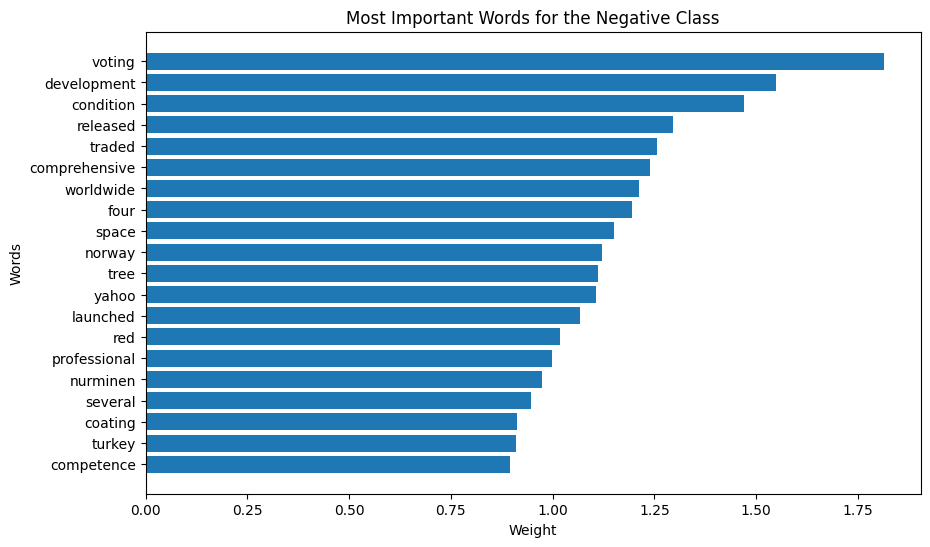

In [43]:
# Criar gráfico de barras para palavras negativas
plt.figure(figsize=(10, 6))
plt.barh(importancias_negativas['Feature'][:20], importancias_negativas['Peso'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Negative Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [44]:
class_index = 1
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_neutras = pd.DataFrame({'Feature': nomes_das_features, 'Peso': word_importances})
importancias_neutras = importancias_neutras.sort_values(by='Peso', ascending=False)

print("Most important features for the Neutral class:")
print(importancias_neutras.head(20))

Most important features for the Neutral class:
             Feature      Peso
1082   comprehensive  1.421645
1121      specialist  1.385378
35             today  1.268968
350             four  1.140729
73       development  1.093816
787       comparable  1.092152
910          citycon  1.061107
2055      repurchase  1.050361
1319          coated  0.989063
516          manager  0.966398
298      performance  0.959961
3286  affectogenimap  0.947612
1798         newpage  0.941902
3370          diapol  0.940040
501            space  0.938711
284         chairman  0.931246
63      construction  0.929292
1083           matti  0.888657
1808            keep  0.871758
4               said  0.868493


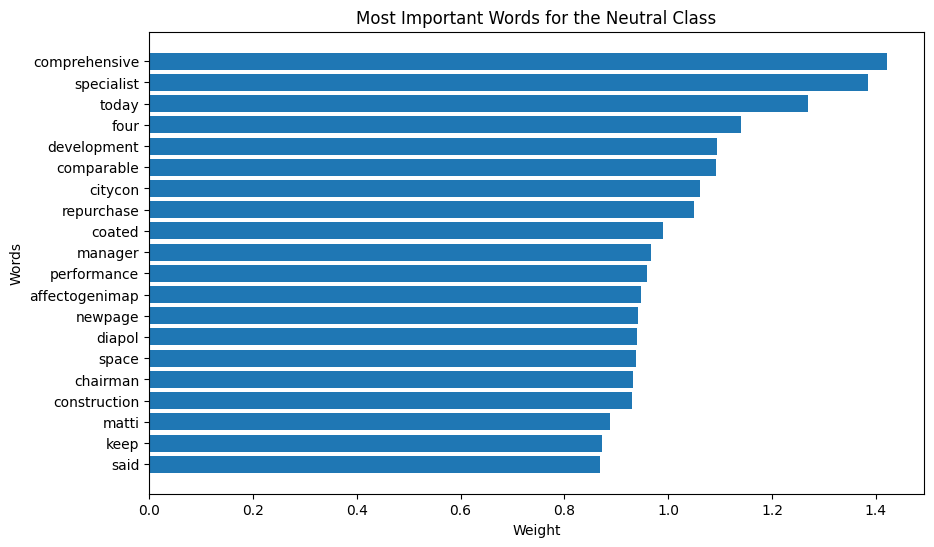

In [45]:
# Criar gráfico de barras para palavras neutras
plt.figure(figsize=(10, 6))
plt.barh(importancias_neutras['Feature'][:20], importancias_neutras['Peso'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Neutral Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [46]:
class_index = 2
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_positivas = pd.DataFrame({'Feature': nomes_das_features, 'Peso': word_importances})
importancias_positivas = importancias_positivas.sort_values(by='Peso', ascending=False)

print("Most important features for the Positive class:")
print(importancias_positivas.head(20))

Most important features for the Positive class:
          Feature      Peso
275       leading  1.221832
1386       valued  1.215923
447         chief  1.180294
1709  uncertainty  1.173594
879        street  1.154182
575          call  1.118571
3393          avc  1.117100
662        leader  1.090059
726          book  1.073377
148           say  1.072814
664       biggest  1.059858
807         waste  1.049299
1700        kuitu  1.045493
498          name  1.039122
1985         flat  1.033368
3298         prof  1.021550
2043      turnkey  1.004087
587     continued  1.000127
1000        kroon  0.998663
1429         cell  0.992979


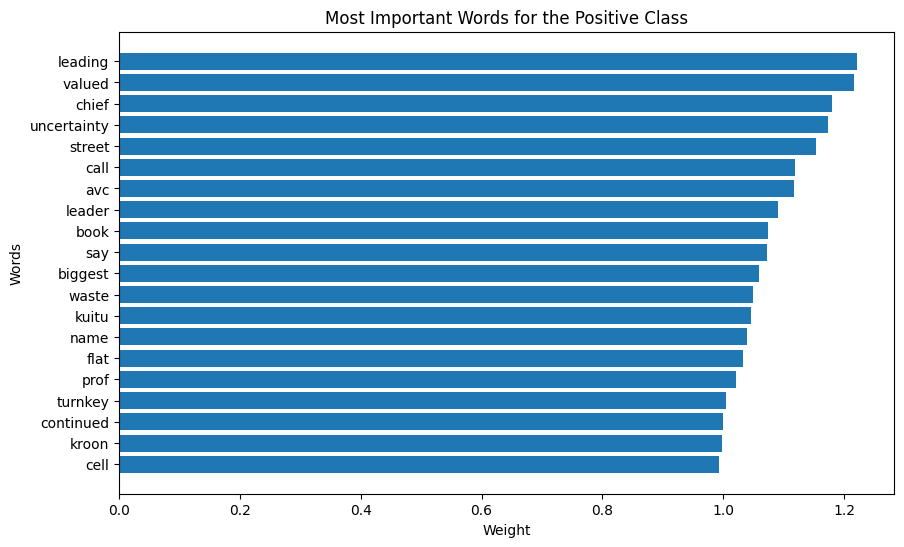

In [47]:
# Criar gráfico de barras para palavras positivas
plt.figure(figsize=(10, 6))
plt.barh(importancias_positivas['Feature'][:20], importancias_positivas['Peso'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Positive Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()